# Project: Finding Donors for *CharityML*
## Supervised Learning

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
from sklearn import linear_model

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.tail(n=5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
45217,33,Private,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Male,0.0,0.0,40.0,United-States,<=50K
45218,39,Private,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K
45219,38,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
45220,44,Private,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K
45221,35,Self-emp-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, we will compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [3]:
# TODO: Total number of records
n_records = float(data.shape[0])

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = float(len(data[data['income'] == '>50K']))

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == '<=50K'])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = float((n_greater_50k/n_records)*100)

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222.0
Individuals making more than $50,000: 11208.0
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


In [3]:
data.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


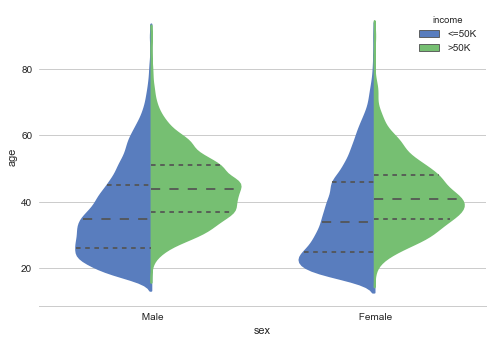

In [6]:
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x="sex", y="age", hue="income", data=data, split=True, 
               inner="quart", palette="muted"
              )
sns.despine(left=True)

We can see in the the income category distribution in the above chart based on differen ages for two different sex (male and female)

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

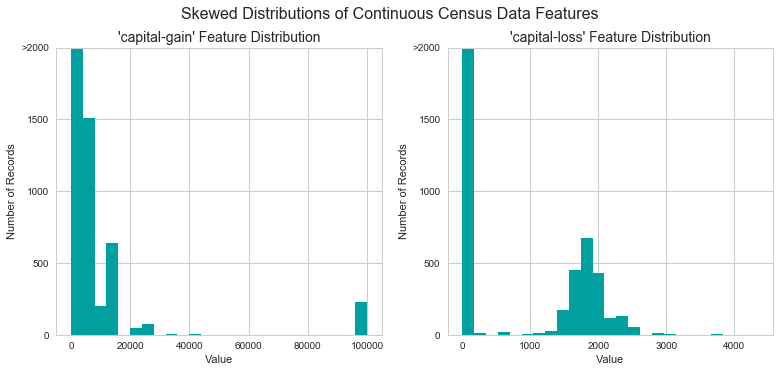

In [7]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

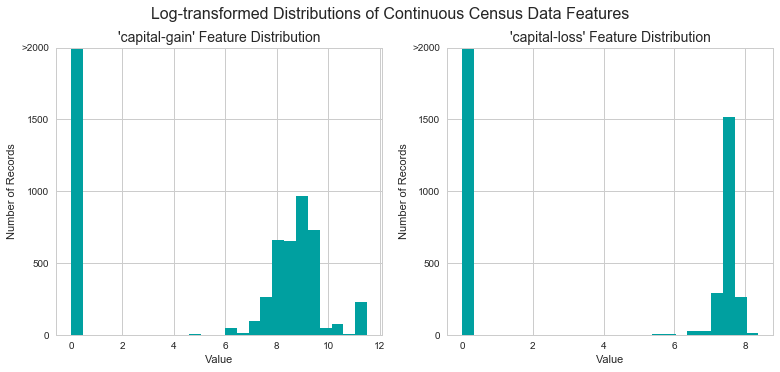

In [8]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [9]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(features_raw[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [10]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
#income = {"income" : {"<=50K": 0, ">50K" : 1}}
#income_raw.replace(income, inplace=True)
income = income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded
print "This is how income looks like after character encoding - "
income.head(5)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

0    0
1    0
2    0
3    0
4    0
Name: income, dtype: int64

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [11]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. 

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  

In [12]:
# TODO: Calculate accuracy
## 4 importannt variables for calculating Accuracy , Precision and Recall
## True Positive (TP), False Positive (FP), False Negative (FN), True Negative (TN)
## In our case as the model predicts an individual always make more than 50k , FN & TN will be 0

## Accuracy = TP+TN/(TP+FP+TN+FN)
## Precision = TP/(TP+FP)
## Recall = TP/(TP+FN)

accuracy = (n_greater_50k+0) / (n_greater_50k + n_at_most_50k+0+0) 

# TODO: Calculate F-score using the formula above for beta = 0.5
precision = n_greater_50k / (n_greater_50k + n_at_most_50k)
recall = n_greater_50k / (n_greater_50k + 0)
beta = 0.5

fscore = (1+beta**2) * ((precision * recall) / (beta**2 * precision + recall))


# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that we may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Naive Bayes:** <br>
One of the best industry application of Naive Bayes algorithm is Spam email filtering. <br>

Due to its simplicity, this algorithm might outperform more complex models when the data set isn’t large enough. <br>

However, the disadvantage of the model is that it makes a strong assumption about the independence of the features which is why it is called as Naive Classifier. Additionally, this algorithm performs poorly in case the words used are not as relevant as the order in which they’re written.<br>

Naive Bayes is an eager learning classifier, which makes it time efficient when we are working on large datasets. Time efficiency feature of Naive Bayes algorithm makes it a good candidate for our case. 

**SGD Classifier**<br>
Stochastic Gradient descent is among the most common techniques used for optimization in practice. <br>

The advantages of Stochastic Gradient Descent are:<br>
- Efficiency.
- Ease of implementation (lots of opportunities for code tuning).<br>

The disadvantages of Stochastic Gradient Descent include: <br>
- SGD requires a number of hyper-parameters such as the regularization parameter and the number of iterations.
- SGD is sensitive to feature scaling. <br>

SGD algorithm uses only one training sample and it starts improving itself right away from the first sample which makes the SGD computationally whole lot faster. This particular feature of SGD classifier makes it a good candidate for our problem in terms of time efficiency. <br>

**Support Vector Machines (SVM): **<br>
[SVM](https://en.wikipedia.org/wiki/Support_vector_machine) has been used successfully in many real-world problems such as.  
- text (and hypertext) categorization
- image classification <br>

The advantages of support vector machines are:<br>
- Effective in high dimensional spaces.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient. <br>

The disadvantages of support vector machines include:
- If the number of features is much greater than the number of samples, the method is likely to give poor performances. <br>

SVM is a good candidate for the given problem because SVM usually maximizes margin, which makes the classification model is slightly more robust.


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [13]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train, beta = 0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test, beta = 0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
SGDClassifier trained on 361 samples.
SGDClassifier trained on 3617 samples.
SGDClassifier trained on 36177 samples.


/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.


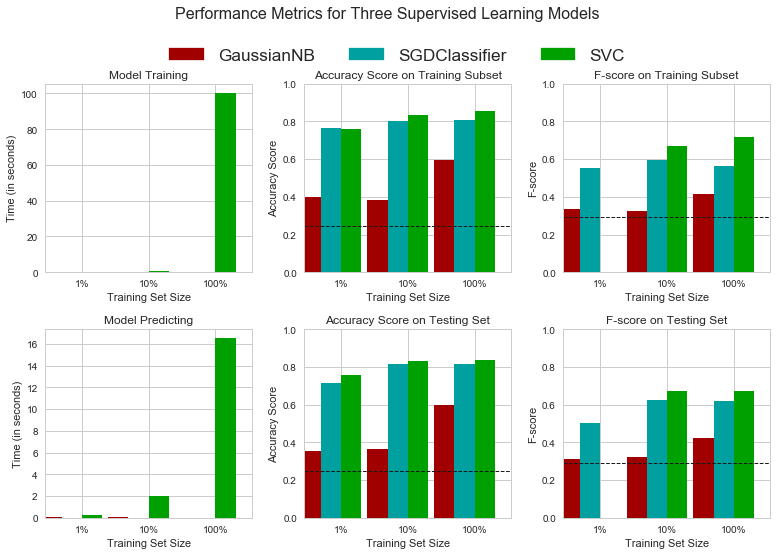

In [14]:
# TODO: Import the three supervised learning models from sklearn
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = SGDClassifier(random_state = 32)
clf_C = svm.SVC(random_state = 32)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(len(X_train) * 0.01)
samples_10 = int(len(X_train) * 0.1)
samples_100 =int(len(X_train) * 1)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

Below are the specific values of training results we displayed in the chart above - 

In [15]:
for i in results.items():
    print i[0]
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

GaussianNB


,1%,10%,100%
acc_test,0.351797,0.366059,0.597678
acc_train,0.400000,0.383333,0.593333
f_test,0.310134,0.320258,0.420899
f_train,0.333333,0.325092,0.412500
pred_time,0.030552,0.029527,0.022198
train_time,0.002618,0.023141,0.143996


SGDClassifier


,1%,10%,100%
acc_test,0.717634,0.816584,0.816363
acc_train,0.766667,0.803333,0.806667
f_test,0.504523,0.623893,0.621601
f_train,0.554577,0.593434,0.562500
pred_time,0.005166,0.004362,0.003901
train_time,0.002086,0.022933,0.099467


SVC


,1%,10%,100%
acc_test,0.756219,0.832615,0.837148
acc_train,0.760000,0.833333,0.853333
f_test,0.000000,0.671256,0.674477
f_train,0.000000,0.671296,0.719697
pred_time,0.233352,1.985406,16.523955
train_time,0.013751,0.903674,100.420808


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  

Based on the graphs above, we will analyze the performence of three different classifiers we have worked with - <br>
**GausianNB()** <br>
1. We can see that, increasing the sample size from 1% to 100% doesn't affect  the Model training and Model prediction time. 
2. As the training size increases from 10% to 100%, the accuracy score increases approximately by 0.4 to reach 0.6. That's the best accuracy score we have for GausianNB model.
3. Best F1 score we have is 0.4 <br>

**SGDClassifier()** <br>
1. We can see that, increasing the sample size from 1% to 100% doesn't affect  the Model training and Model prediction time much. 
2. For this classifier, accuracy score for both training and testing set is pretty consistant at around 0.8 throughout varied sample sizes.
3. We can see a increased F1 score when sample size is moved from 1% to 10% of data for training model. Whereas, for testing data, F1 score is pretty much around 0.6 <br>

**SVC()**<br>
1. We can see that, increasing the sample size from 10% to 100% increses the training as well as testing time drastically.
2. For this classifier, we have the best accuracy score at 0.8 for both training and testing data for various sample sizes.
3. For training set F score increases a little bit when we move from 10% to 100% subset of data. Whereas, for testing data we can see a pretty much same F score around 0.65 for both sample sizes <br>

***Conclusion - ***<br>
- Based on the above observation we can say that SGDClassifier and SVC model are the top 2 best performing supervised learning models.
- While training a model and testing the fitted model, as we increase the data sample size, SVC take considerbly more time that the SGDClassifier.
- In terms of accuracy score and F1 score, SVC gives a very little increase in these scores at the cost of increases time for training a model and predicting the data. <br>

*Therefore, We will be using SGDClassifier further down the project and work on making it better by parameter tuning.*

### Describing the Model in Layman's Terms <br>

Stochastic gradient descent is a simple but efficient numerical optimization method. It has been widely used in solving large-scale machine learning problems.
**Intuitive Explanation -** <br>
Suppose you have to go from A to E and you don't know the directions to reach E. But you can call 20 customer care numbers you have and get directions. In this case, first you go to B from A and call one random customer care number and get directions. while going from C to D you repeat the same step of randomly calling one customer care number to get directions. <br>
Similarlly, in SGD, the algorithm work by building your model on small set of data and keep repeating the same procedure untill you reach the optimized model.<br>


One benefit of SGD is that it's computationally a whole lot faster. Usually, this computational advantage is leveraged by performing many more iterations of SGD, making many more steps than conventional batch gradient descent.
With the given problem we have a feature scaled dataset alongwith an opportunity to gain more flexibility while implementing SGD Classifier by tuning the various parameters which makes this algorithm a good candidate for the given problem.

### Implementation: Model Tuning
Let's fine tune the chosen model. We will use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

In [17]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn import grid_search
from sklearn.metrics import make_scorer


# TODO: Initialize the classifier
clf = linear_model.SGDClassifier(random_state = 32)

# TODO: Create the parameters list you wish to tune
parameters = {'learning_rate' : ['optimal','invscaling'],
             'alpha' : [0.1, 0.005,0.0004,0.0002],
             'penalty': ['l2','elasticnet','l1'],
             'n_iter': [500], 'eta0': [3]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta = 0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = grid_search.GridSearchCV(clf, parameters, cv=None, scoring = scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8164
F-score on testing data: 0.6216

Optimized Model
------
Final accuracy score on the testing data: 0.8401
Final F-score on the testing data: 0.6836


### Final Model Evaluation

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |     0.2478          |    0.8164         |     0.8401      |
| F-score        |     0.2917          |    0.6216         |     0.6836      |


 Optimized Model Performance - <br>
- Accuracy Score : 0.8401 <br>
- F Score : 0.6836 <br>
The over all acuracy based on Acuracy score and F-score is better for our optimized model when compared to the unoptimized model. Although, compared to our Naive Predictor that we calculated at the start, we have a much better accuracy scores. 


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

By simply looking at the data we can say that these might the most important feature for predicting the salary level of a person - <br>
   - relationship : Considering we have been given census data for household, a family with multiple people will usually have more income than a single person earning.<br>
   
   - education_level: Because education level decided the pay scale range a person falls in to. Usually, A person with Bachelors / masters degree will earn more than a person with just highschool education <br>
   
   - capital-gain : Because this feature indicates how much was the exact capital gain dollar value for a particular person. This gives us more idea about the income level of a person <br>
   
   - Occupation : A person at managerial position usually will earn more than a person at a clerical position. <br>
   
   - Age : Usually as a person's age increases, he gains more experience along with better compensation with each promotion. 

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm. You may choose any algorithm you want.

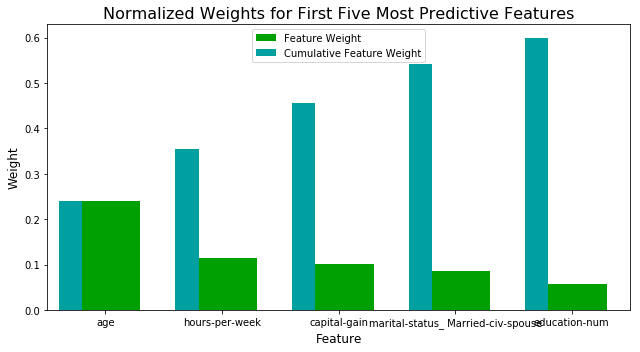

In [26]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

# TODO: Train the supervised model on the training set 
model = RandomForestClassifier(n_estimators=10,random_state = 32)
model.fit(X_train,y_train)


# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  

As per our analysis in above which was solely based on looking at the data, we are pretty close to guessing the five features which are more important while making predictions. The only feature that we did not include in the original list was 'hours-per-week'. As per my understanding, your income depends more on how much you earn in an hour compare to how many hours you work in a week. But as per the feature importance test we did above, it's clear that even though 'Hour-per-week' carries less importance, it is still important in terms of bulding a predictive model.<br>

As you can see in the above graph, 'relation' feature gets the most weight in terms of importance and it is the same first feature we listed in our observation above. As you observe the graph more, we have our five most important features (given by feature_importance in sklearn) arranged in an ascending order.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [19]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8401
F-score on testing data: 0.6836

Final Model trained on reduced data
------
Accuracy on testing data: 0.7766
F-score on testing data: 0.4472


### Effects of Feature Selection

Even though we reduced the data dimensionality by almost one third, the accuracy of the model has not decreased drastically. Although, the F-score for the model has decreased to 0.50 from 0.68. But considering the time factor, as the dimensionally reduced data takes considerably less amount of time to build the model, we can consider using reduced data as our training set.